In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=0
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


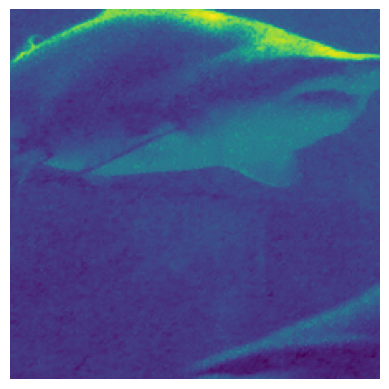

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 1.1218


Epoch 1, Batch 2, LR: 0.000050, Loss: 1.0333


Epoch 1, Batch 3, LR: 0.000050, Loss: 0.9921


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.9461


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.9027


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.8737


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.8458


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.8313


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.8365


Epoch 1, Batch 10, LR: 0.000050, Loss: 0.7744


Epoch 1, Batch 11, LR: 0.000050, Loss: 0.7473


Epoch 1, Batch 12, LR: 0.000050, Loss: 0.7498


Epoch 1, Batch 13, LR: 0.000050, Loss: 0.7515


Epoch 1, Batch 14, LR: 0.000050, Loss: 0.7154


Epoch 1, Batch 15, LR: 0.000050, Loss: 0.7197


Epoch 1, Batch 16, LR: 0.000050, Loss: 0.7288


Epoch 1, Batch 17, LR: 0.000050, Loss: 0.7242


Epoch 1, Batch 18, LR: 0.000050, Loss: 0.7133


Epoch 1, Batch 19, LR: 0.000050, Loss: 0.6818


Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6997


Epoch 1, Batch 21, LR: 0.000050, Loss: 0.6868


Epoch 1, Batch 22, LR: 0.000050, Loss: 0.6923


Epoch 1, Batch 23, LR: 0.000050, Loss: 0.6924


Epoch 1, Batch 24, LR: 0.000050, Loss: 0.6748


Epoch 1, Batch 25, LR: 0.000050, Loss: 0.6603


Epoch 1, Batch 26, LR: 0.000050, Loss: 0.6610


Epoch 1, Batch 27, LR: 0.000050, Loss: 0.6594


Epoch 1, Batch 28, LR: 0.000050, Loss: 0.6648


Epoch 1, Batch 29, LR: 0.000050, Loss: 0.6582


Epoch 1, Batch 30, LR: 0.000050, Loss: 0.6501


Epoch 1, Batch 31, LR: 0.000050, Loss: 0.6683


Epoch 1, Batch 32, LR: 0.000049, Loss: 0.6756


Epoch 1, Batch 33, LR: 0.000049, Loss: 0.6629


Epoch 1, Batch 34, LR: 0.000049, Loss: 0.6466


Epoch 1, Batch 35, LR: 0.000049, Loss: 0.6472


Epoch 1, Batch 36, LR: 0.000049, Loss: 0.6385


Epoch 1, Batch 37, LR: 0.000049, Loss: 0.6309


Epoch 1, Batch 38, LR: 0.000049, Loss: 0.6426


Epoch 1, Batch 39, LR: 0.000049, Loss: 0.6462


Epoch 1, Batch 40, LR: 0.000049, Loss: 0.6521


Epoch 1, Batch 41, LR: 0.000049, Loss: 0.6379


Epoch 1, Batch 42, LR: 0.000049, Loss: 0.6359


Epoch 1, Batch 43, LR: 0.000049, Loss: 0.6278


Epoch 1, Batch 44, LR: 0.000049, Loss: 0.6513


Epoch 1, Batch 45, LR: 0.000049, Loss: 0.6407


Epoch 1, Batch 46, LR: 0.000049, Loss: 0.6365


Epoch 1, Batch 47, LR: 0.000049, Loss: 0.6404


Epoch 1, Batch 48, LR: 0.000049, Loss: 0.6416


Epoch 1, Batch 49, LR: 0.000049, Loss: 0.6414


Epoch 1, Batch 50, LR: 0.000049, Loss: 0.6416


Epoch 1, Batch 51, LR: 0.000049, Loss: 0.6377


Epoch 1, Batch 52, LR: 0.000049, Loss: 0.6199


Epoch 1, Batch 53, LR: 0.000049, Loss: 0.6282


Epoch 1, Batch 54, LR: 0.000049, Loss: 0.6294


Epoch 1, Batch 55, LR: 0.000049, Loss: 0.6399


Epoch 1, Batch 56, LR: 0.000048, Loss: 0.6239


Epoch 1, Batch 57, LR: 0.000048, Loss: 0.6283


Epoch 1, Batch 58, LR: 0.000048, Loss: 0.6274


Epoch 1, Batch 59, LR: 0.000048, Loss: 0.6379


Epoch 1, Batch 60, LR: 0.000048, Loss: 0.6243


Epoch 1, Batch 61, LR: 0.000048, Loss: 0.6243


Epoch 1, Batch 62, LR: 0.000048, Loss: 0.6169


Epoch 1, Batch 63, LR: 0.000048, Loss: 0.6259


Epoch 1, Batch 64, LR: 0.000048, Loss: 0.6100


Epoch 1, Batch 65, LR: 0.000048, Loss: 0.6281


Epoch 1, Batch 66, LR: 0.000048, Loss: 0.6133


Epoch 1, Batch 67, LR: 0.000048, Loss: 0.6230


Epoch 1, Batch 68, LR: 0.000048, Loss: 0.6173


Epoch 1, Batch 69, LR: 0.000048, Loss: 0.6163


Epoch 1, Batch 70, LR: 0.000048, Loss: 0.6117


Epoch 1, Batch 71, LR: 0.000048, Loss: 0.6152


Epoch 1, Batch 72, LR: 0.000047, Loss: 0.6093


Epoch 1, Batch 73, LR: 0.000047, Loss: 0.6187


Epoch 1, Batch 74, LR: 0.000047, Loss: 0.6142


Epoch 1, Batch 75, LR: 0.000047, Loss: 0.6308


Epoch 1, Batch 76, LR: 0.000047, Loss: 0.6076


Epoch 1, Batch 77, LR: 0.000047, Loss: 0.6049


Epoch 1, Batch 78, LR: 0.000047, Loss: 0.6308


Epoch 1, Batch 79, LR: 0.000047, Loss: 0.6204


Epoch 1, Batch 80, LR: 0.000047, Loss: 0.5965


Epoch 1, Batch 81, LR: 0.000047, Loss: 0.6118


Epoch 1, Batch 82, LR: 0.000047, Loss: 0.6080


Epoch 1, Batch 83, LR: 0.000047, Loss: 0.6006


Epoch 1, Batch 84, LR: 0.000047, Loss: 0.6181


Epoch 1, Batch 85, LR: 0.000047, Loss: 0.6068


Epoch 1, Batch 86, LR: 0.000046, Loss: 0.6120


Epoch 1, Batch 87, LR: 0.000046, Loss: 0.6162


Epoch 1, Batch 88, LR: 0.000046, Loss: 0.6237


Epoch 1, Batch 89, LR: 0.000046, Loss: 0.6111


Epoch 1, Batch 90, LR: 0.000046, Loss: 0.6025


Epoch 1, Batch 91, LR: 0.000046, Loss: 0.6054


Epoch 1, Batch 92, LR: 0.000046, Loss: 0.5993


Epoch 1, Batch 93, LR: 0.000046, Loss: 0.6288


Epoch 1, Batch 94, LR: 0.000046, Loss: 0.6044


Epoch 1, Batch 95, LR: 0.000046, Loss: 0.5968


Epoch 1, Batch 96, LR: 0.000046, Loss: 0.6228


Epoch 1, Batch 97, LR: 0.000045, Loss: 0.6111


Epoch 1, Batch 98, LR: 0.000045, Loss: 0.6186


Epoch 1, Batch 99, LR: 0.000045, Loss: 0.6059


Epoch 1, Batch 100, LR: 0.000045, Loss: 0.6117


Epoch 1, Batch 101, LR: 0.000045, Loss: 0.6137


Epoch 1, Batch 102, LR: 0.000045, Loss: 0.6094


Epoch 1, Batch 103, LR: 0.000045, Loss: 0.6025


Epoch 1, Batch 104, LR: 0.000045, Loss: 0.6067


Epoch 1, Batch 105, LR: 0.000045, Loss: 0.6129


Epoch 1, Batch 106, LR: 0.000045, Loss: 0.6128


Epoch 1, Batch 107, LR: 0.000045, Loss: 0.6050


Epoch 1, Batch 108, LR: 0.000044, Loss: 0.6022


Epoch 1, Batch 109, LR: 0.000044, Loss: 0.6099


Epoch 1, Batch 110, LR: 0.000044, Loss: 0.6114


Epoch 1, Batch 111, LR: 0.000044, Loss: 0.6123


Epoch 1, Batch 112, LR: 0.000044, Loss: 0.6047


Epoch 1, Batch 113, LR: 0.000044, Loss: 0.5993


Epoch 1, Batch 114, LR: 0.000044, Loss: 0.5991


Epoch 1, Batch 115, LR: 0.000044, Loss: 0.6080


Epoch 1, Batch 116, LR: 0.000044, Loss: 0.6011


Epoch 1, Batch 117, LR: 0.000044, Loss: 0.6286


Epoch 1, Batch 118, LR: 0.000043, Loss: 0.6150


Epoch 1, Batch 119, LR: 0.000043, Loss: 0.6079


Epoch 1, Batch 120, LR: 0.000043, Loss: 0.6065


Epoch 1, Batch 121, LR: 0.000043, Loss: 0.6042


Epoch 1, Batch 122, LR: 0.000043, Loss: 0.5938


Epoch 1, Batch 123, LR: 0.000043, Loss: 0.5925


Epoch 1, Batch 124, LR: 0.000043, Loss: 0.6080


Epoch 1, Batch 125, LR: 0.000043, Loss: 0.5997


Epoch 1, Batch 126, LR: 0.000043, Loss: 0.6131


Epoch 1, Batch 127, LR: 0.000042, Loss: 0.6008


Epoch 1, Batch 128, LR: 0.000042, Loss: 0.6079


Epoch 1, Batch 129, LR: 0.000042, Loss: 0.5985


Epoch 1, Batch 130, LR: 0.000042, Loss: 0.6034


Epoch 1, Batch 131, LR: 0.000042, Loss: 0.5987


Epoch 1, Batch 132, LR: 0.000042, Loss: 0.5942


Epoch 1, Batch 133, LR: 0.000042, Loss: 0.5930


Epoch 1, Batch 134, LR: 0.000042, Loss: 0.6061


Epoch 1, Batch 135, LR: 0.000042, Loss: 0.6038


Epoch 1, Batch 136, LR: 0.000041, Loss: 0.6027


Epoch 1, Batch 137, LR: 0.000041, Loss: 0.5999


Epoch 1, Batch 138, LR: 0.000041, Loss: 0.5950


Epoch 1, Batch 139, LR: 0.000041, Loss: 0.6160


Epoch 1, Batch 140, LR: 0.000041, Loss: 0.6012


Epoch 1, Batch 141, LR: 0.000041, Loss: 0.5845


Epoch 1, Batch 142, LR: 0.000041, Loss: 0.6022


Epoch 1, Batch 143, LR: 0.000041, Loss: 0.6203


Epoch 1, Batch 144, LR: 0.000040, Loss: 0.6005


Epoch 1, Batch 145, LR: 0.000040, Loss: 0.5884


Epoch 1, Batch 146, LR: 0.000040, Loss: 0.6119


Epoch 1, Batch 147, LR: 0.000040, Loss: 0.5934


Epoch 1, Batch 148, LR: 0.000040, Loss: 0.5947


Epoch 1, Batch 149, LR: 0.000040, Loss: 0.5913


Epoch 1, Batch 150, LR: 0.000040, Loss: 0.6043


Epoch 1, Batch 151, LR: 0.000040, Loss: 0.5997


Epoch 1, Batch 152, LR: 0.000039, Loss: 0.6058


Epoch 1, Batch 153, LR: 0.000039, Loss: 0.5818


Epoch 1, Batch 154, LR: 0.000039, Loss: 0.6003


Epoch 1, Batch 155, LR: 0.000039, Loss: 0.5958


Epoch 1, Batch 156, LR: 0.000039, Loss: 0.5992


Epoch 1, Batch 157, LR: 0.000039, Loss: 0.5994


Epoch 1, Batch 158, LR: 0.000039, Loss: 0.5992


Epoch 1, Batch 159, LR: 0.000039, Loss: 0.5762


Epoch 1, Batch 160, LR: 0.000038, Loss: 0.5918


Epoch 1, Batch 161, LR: 0.000038, Loss: 0.5897


Epoch 1, Batch 162, LR: 0.000038, Loss: 0.6085


Epoch 1, Batch 163, LR: 0.000038, Loss: 0.5892


Epoch 1, Batch 164, LR: 0.000038, Loss: 0.6026


Epoch 1, Batch 165, LR: 0.000038, Loss: 0.5907


Epoch 1, Batch 166, LR: 0.000038, Loss: 0.5858


Epoch 1, Batch 167, LR: 0.000037, Loss: 0.5955


Epoch 1, Batch 168, LR: 0.000037, Loss: 0.6025


Epoch 1, Batch 169, LR: 0.000037, Loss: 0.6185


Epoch 1, Batch 170, LR: 0.000037, Loss: 0.6072


Epoch 1, Batch 171, LR: 0.000037, Loss: 0.6000


Epoch 1, Batch 172, LR: 0.000037, Loss: 0.5878


Epoch 1, Batch 173, LR: 0.000037, Loss: 0.5960


Epoch 1, Batch 174, LR: 0.000036, Loss: 0.6021


Epoch 1, Batch 175, LR: 0.000036, Loss: 0.6002


Epoch 1, Batch 176, LR: 0.000036, Loss: 0.5906


Epoch 1, Batch 177, LR: 0.000036, Loss: 0.5938


Epoch 1, Batch 178, LR: 0.000036, Loss: 0.5956


Epoch 1, Batch 179, LR: 0.000036, Loss: 0.5898


Epoch 1, Batch 180, LR: 0.000036, Loss: 0.6064


Epoch 1, Batch 181, LR: 0.000036, Loss: 0.5914


Epoch 1, Batch 182, LR: 0.000035, Loss: 0.5928


Epoch 1, Batch 183, LR: 0.000035, Loss: 0.6150


Epoch 1, Batch 184, LR: 0.000035, Loss: 0.5865


Epoch 1, Batch 185, LR: 0.000035, Loss: 0.6079


Epoch 1, Batch 186, LR: 0.000035, Loss: 0.5878


Epoch 1, Batch 187, LR: 0.000035, Loss: 0.5918


Epoch 1, Batch 188, LR: 0.000034, Loss: 0.6019


Epoch 1, Batch 189, LR: 0.000034, Loss: 0.5887


Epoch 1, Batch 190, LR: 0.000034, Loss: 0.6097


Epoch 1, Batch 191, LR: 0.000034, Loss: 0.5977


Epoch 1, Batch 192, LR: 0.000034, Loss: 0.5876


Epoch 1, Batch 193, LR: 0.000034, Loss: 0.6002


Epoch 1, Batch 194, LR: 0.000034, Loss: 0.5984


Epoch 1, Batch 195, LR: 0.000033, Loss: 0.5901


Epoch 1, Batch 196, LR: 0.000033, Loss: 0.6105


Epoch 1, Batch 197, LR: 0.000033, Loss: 0.5827


Epoch 1, Batch 198, LR: 0.000033, Loss: 0.5963


Epoch 1, Batch 199, LR: 0.000033, Loss: 0.6019


Epoch 1, Batch 200, LR: 0.000033, Loss: 0.6023


Epoch 1, Batch 201, LR: 0.000033, Loss: 0.6172


Epoch 1, Batch 202, LR: 0.000032, Loss: 0.6028


Epoch 1, Batch 203, LR: 0.000032, Loss: 0.6045


Epoch 1, Batch 204, LR: 0.000032, Loss: 0.5881


Epoch 1, Batch 205, LR: 0.000032, Loss: 0.5858


Epoch 1, Batch 206, LR: 0.000032, Loss: 0.5882


Epoch 1, Batch 207, LR: 0.000032, Loss: 0.6066


Epoch 1, Batch 208, LR: 0.000032, Loss: 0.6084


Epoch 1, Batch 209, LR: 0.000031, Loss: 0.5880


Epoch 1, Batch 210, LR: 0.000031, Loss: 0.5889


Epoch 1, Batch 211, LR: 0.000031, Loss: 0.5820


Epoch 1, Batch 212, LR: 0.000031, Loss: 0.5888


Epoch 1, Batch 213, LR: 0.000031, Loss: 0.5978


Epoch 1, Batch 214, LR: 0.000031, Loss: 0.5859


Epoch 1, Batch 215, LR: 0.000030, Loss: 0.5957


Epoch 1, Batch 216, LR: 0.000030, Loss: 0.6027


Epoch 1, Batch 217, LR: 0.000030, Loss: 0.5766


Epoch 1, Batch 218, LR: 0.000030, Loss: 0.5960


Epoch 1, Batch 219, LR: 0.000030, Loss: 0.6016


Epoch 1, Batch 220, LR: 0.000030, Loss: 0.6095


Epoch 1, Batch 221, LR: 0.000030, Loss: 0.5939


Epoch 1, Batch 222, LR: 0.000029, Loss: 0.5907


Epoch 1, Batch 223, LR: 0.000029, Loss: 0.6055


Epoch 1, Batch 224, LR: 0.000029, Loss: 0.5859


Epoch 1, Batch 225, LR: 0.000029, Loss: 0.5832


Epoch 1, Batch 226, LR: 0.000029, Loss: 0.5951


Epoch 1, Batch 227, LR: 0.000029, Loss: 0.5973


Epoch 1, Batch 228, LR: 0.000028, Loss: 0.5804


Epoch 1, Batch 229, LR: 0.000028, Loss: 0.5915


Epoch 1, Batch 230, LR: 0.000028, Loss: 0.5843


Epoch 1, Batch 231, LR: 0.000028, Loss: 0.5847


Epoch 1, Batch 232, LR: 0.000028, Loss: 0.5872


Epoch 1, Batch 233, LR: 0.000028, Loss: 0.6048


Epoch 1, Batch 234, LR: 0.000028, Loss: 0.6101


Epoch 1, Batch 235, LR: 0.000027, Loss: 0.5833


Epoch 1, Batch 236, LR: 0.000027, Loss: 0.5879


Epoch 1, Batch 237, LR: 0.000027, Loss: 0.5935


Epoch 1, Batch 238, LR: 0.000027, Loss: 0.5995


Epoch 1, Batch 239, LR: 0.000027, Loss: 0.6011


Epoch 1, Batch 240, LR: 0.000027, Loss: 0.6020


Epoch 1, Batch 241, LR: 0.000026, Loss: 0.5910


Epoch 1, Batch 242, LR: 0.000026, Loss: 0.5967


Epoch 1, Batch 243, LR: 0.000026, Loss: 0.5980


Epoch 1, Batch 244, LR: 0.000026, Loss: 0.6093


Epoch 1, Batch 245, LR: 0.000026, Loss: 0.5979


Epoch 1, Batch 246, LR: 0.000026, Loss: 0.5994


Epoch 1, Batch 247, LR: 0.000025, Loss: 0.6030


Epoch 1, Batch 248, LR: 0.000025, Loss: 0.5958


Epoch 1, Batch 249, LR: 0.000025, Loss: 0.5840


Epoch 1, Batch 250, LR: 0.000025, Loss: 0.5933


Epoch 1, Batch 251, LR: 0.000025, Loss: 0.6045


Epoch 1, Batch 252, LR: 0.000025, Loss: 0.5944


Epoch 1, Batch 253, LR: 0.000025, Loss: 0.6013


Epoch 1, Batch 254, LR: 0.000024, Loss: 0.6101


Epoch 1, Batch 255, LR: 0.000024, Loss: 0.5829


Epoch 1, Batch 256, LR: 0.000024, Loss: 0.5924


Epoch 1, Batch 257, LR: 0.000024, Loss: 0.5852


Epoch 1, Batch 258, LR: 0.000024, Loss: 0.5996


Epoch 1, Batch 259, LR: 0.000024, Loss: 0.5917


Epoch 1, Batch 260, LR: 0.000023, Loss: 0.6084


Epoch 1, Batch 261, LR: 0.000023, Loss: 0.5815


Epoch 1, Batch 262, LR: 0.000023, Loss: 0.5918


Epoch 1, Batch 263, LR: 0.000023, Loss: 0.6033


Epoch 1, Batch 264, LR: 0.000023, Loss: 0.6061


Epoch 1, Batch 265, LR: 0.000023, Loss: 0.5896


Epoch 1, Batch 266, LR: 0.000022, Loss: 0.5769


Epoch 1, Batch 267, LR: 0.000022, Loss: 0.5810


Epoch 1, Batch 268, LR: 0.000022, Loss: 0.5957


Epoch 1, Batch 269, LR: 0.000022, Loss: 0.6023


Epoch 1, Batch 270, LR: 0.000022, Loss: 0.5654


Epoch 1, Batch 271, LR: 0.000022, Loss: 0.5893


Epoch 1, Batch 272, LR: 0.000022, Loss: 0.5908


Epoch 1, Batch 273, LR: 0.000021, Loss: 0.6047


Epoch 1, Batch 274, LR: 0.000021, Loss: 0.5819


Epoch 1, Batch 275, LR: 0.000021, Loss: 0.5914


Epoch 1, Batch 276, LR: 0.000021, Loss: 0.5806


Epoch 1, Batch 277, LR: 0.000021, Loss: 0.5806


Epoch 1, Batch 278, LR: 0.000021, Loss: 0.6071


Epoch 1, Batch 279, LR: 0.000020, Loss: 0.5893


Epoch 1, Batch 280, LR: 0.000020, Loss: 0.5856


Epoch 1, Batch 281, LR: 0.000020, Loss: 0.5919


Epoch 1, Batch 282, LR: 0.000020, Loss: 0.5921


Epoch 1, Batch 283, LR: 0.000020, Loss: 0.5966


Epoch 1, Batch 284, LR: 0.000020, Loss: 0.5914


Epoch 1, Batch 285, LR: 0.000020, Loss: 0.5980


Epoch 1, Batch 286, LR: 0.000019, Loss: 0.5986


Epoch 1, Batch 287, LR: 0.000019, Loss: 0.5896


Epoch 1, Batch 288, LR: 0.000019, Loss: 0.6006


Epoch 1, Batch 289, LR: 0.000019, Loss: 0.5918


Epoch 1, Batch 290, LR: 0.000019, Loss: 0.5850


Epoch 1, Batch 291, LR: 0.000019, Loss: 0.6053


Epoch 1, Batch 292, LR: 0.000018, Loss: 0.5929


Epoch 1, Batch 293, LR: 0.000018, Loss: 0.6047


Epoch 1, Batch 294, LR: 0.000018, Loss: 0.5870


Epoch 1, Batch 295, LR: 0.000018, Loss: 0.6031


Epoch 1, Batch 296, LR: 0.000018, Loss: 0.5833


Epoch 1, Batch 297, LR: 0.000018, Loss: 0.5797


Epoch 1, Batch 298, LR: 0.000018, Loss: 0.5923


Epoch 1, Batch 299, LR: 0.000017, Loss: 0.5932


Epoch 1, Batch 300, LR: 0.000017, Loss: 0.5834


Epoch 1, Batch 301, LR: 0.000017, Loss: 0.5853


Epoch 1, Batch 302, LR: 0.000017, Loss: 0.5811


Epoch 1, Batch 303, LR: 0.000017, Loss: 0.5881


Epoch 1, Batch 304, LR: 0.000017, Loss: 0.6045


Epoch 1, Batch 305, LR: 0.000017, Loss: 0.5896


Epoch 1, Batch 306, LR: 0.000016, Loss: 0.5816


Epoch 1, Batch 307, LR: 0.000016, Loss: 0.6058


Epoch 1, Batch 308, LR: 0.000016, Loss: 0.5966


Epoch 1, Batch 309, LR: 0.000016, Loss: 0.5867


Epoch 1, Batch 310, LR: 0.000016, Loss: 0.5801


Epoch 1, Batch 311, LR: 0.000016, Loss: 0.5793


Epoch 1, Batch 312, LR: 0.000016, Loss: 0.5797


Epoch 1, Batch 313, LR: 0.000015, Loss: 0.6094


Epoch 1, Batch 314, LR: 0.000015, Loss: 0.5857


Epoch 1, Batch 315, LR: 0.000015, Loss: 0.5953


Epoch 1, Batch 316, LR: 0.000015, Loss: 0.5770


Epoch 1, Batch 317, LR: 0.000015, Loss: 0.5935


Epoch 1, Batch 318, LR: 0.000015, Loss: 0.6131


Epoch 1, Batch 319, LR: 0.000014, Loss: 0.5974


Epoch 1, Batch 320, LR: 0.000014, Loss: 0.6020


Epoch 1, Batch 321, LR: 0.000014, Loss: 0.5920


Epoch 1, Batch 322, LR: 0.000014, Loss: 0.5994


Epoch 1, Batch 323, LR: 0.000014, Loss: 0.6039


Epoch 1, Batch 324, LR: 0.000014, Loss: 0.6000


Epoch 1, Batch 325, LR: 0.000014, Loss: 0.6066


Epoch 1, Batch 326, LR: 0.000014, Loss: 0.5921


Epoch 1, Batch 327, LR: 0.000013, Loss: 0.5798


Epoch 1, Batch 328, LR: 0.000013, Loss: 0.5934


Epoch 1, Batch 329, LR: 0.000013, Loss: 0.6015


Epoch 1, Batch 330, LR: 0.000013, Loss: 0.5869


Epoch 1, Batch 331, LR: 0.000013, Loss: 0.5980


Epoch 1, Batch 332, LR: 0.000013, Loss: 0.5902


Epoch 1, Batch 333, LR: 0.000013, Loss: 0.5985


Epoch 1, Batch 334, LR: 0.000012, Loss: 0.5823


Epoch 1, Batch 335, LR: 0.000012, Loss: 0.5959


Epoch 1, Batch 336, LR: 0.000012, Loss: 0.5899


Epoch 1, Batch 337, LR: 0.000012, Loss: 0.6029


Epoch 1, Batch 338, LR: 0.000012, Loss: 0.5856


Epoch 1, Batch 339, LR: 0.000012, Loss: 0.5877


Epoch 1, Batch 340, LR: 0.000012, Loss: 0.5776


Epoch 1, Batch 341, LR: 0.000011, Loss: 0.5985


Epoch 1, Batch 342, LR: 0.000011, Loss: 0.5882


Epoch 1, Batch 343, LR: 0.000011, Loss: 0.6136


Epoch 1, Batch 344, LR: 0.000011, Loss: 0.6071


Epoch 1, Batch 345, LR: 0.000011, Loss: 0.6059


Epoch 1, Batch 346, LR: 0.000011, Loss: 0.5861


Epoch 1, Batch 347, LR: 0.000011, Loss: 0.5993


Epoch 1, Batch 348, LR: 0.000011, Loss: 0.5952


Epoch 1, Batch 349, LR: 0.000010, Loss: 0.6054


Epoch 1, Batch 350, LR: 0.000010, Loss: 0.5892


Epoch 1, Batch 351, LR: 0.000010, Loss: 0.5872


Epoch 1, Batch 352, LR: 0.000010, Loss: 0.5992


Epoch 1, Batch 353, LR: 0.000010, Loss: 0.5970


Epoch 1, Batch 354, LR: 0.000010, Loss: 0.5896


Epoch 1, Batch 355, LR: 0.000010, Loss: 0.5892


Epoch 1, Batch 356, LR: 0.000010, Loss: 0.6074


Epoch 1, Batch 357, LR: 0.000009, Loss: 0.5846


Epoch 1, Batch 358, LR: 0.000009, Loss: 0.5853


Epoch 1, Batch 359, LR: 0.000009, Loss: 0.5846


Epoch 1, Batch 360, LR: 0.000009, Loss: 0.5963


Epoch 1, Batch 361, LR: 0.000009, Loss: 0.5811


Epoch 1, Batch 362, LR: 0.000009, Loss: 0.5862


Epoch 1, Batch 363, LR: 0.000009, Loss: 0.5872


Epoch 1, Batch 364, LR: 0.000009, Loss: 0.5894


Epoch 1, Batch 365, LR: 0.000008, Loss: 0.5935


Epoch 1, Batch 366, LR: 0.000008, Loss: 0.5933


Epoch 1, Batch 367, LR: 0.000008, Loss: 0.6043


Epoch 1, Batch 368, LR: 0.000008, Loss: 0.5873


Epoch 1, Batch 369, LR: 0.000008, Loss: 0.6094


Epoch 1, Batch 370, LR: 0.000008, Loss: 0.6023


Epoch 1, Batch 371, LR: 0.000008, Loss: 0.6012


Epoch 1, Batch 372, LR: 0.000008, Loss: 0.5699


Epoch 1, Batch 373, LR: 0.000008, Loss: 0.5825


Epoch 1, Batch 374, LR: 0.000007, Loss: 0.5876


Epoch 1, Batch 375, LR: 0.000007, Loss: 0.5822


Epoch 1, Batch 376, LR: 0.000007, Loss: 0.5770


Epoch 1, Batch 377, LR: 0.000007, Loss: 0.5920


Epoch 1, Batch 378, LR: 0.000007, Loss: 0.5901


Epoch 1, Batch 379, LR: 0.000007, Loss: 0.5697


Epoch 1, Batch 380, LR: 0.000007, Loss: 0.5881


Epoch 1, Batch 381, LR: 0.000007, Loss: 0.5825


Epoch 1, Batch 382, LR: 0.000007, Loss: 0.5938


Epoch 1, Batch 383, LR: 0.000006, Loss: 0.6019


Epoch 1, Batch 384, LR: 0.000006, Loss: 0.5932


Epoch 1, Batch 385, LR: 0.000006, Loss: 0.5834


Epoch 1, Batch 386, LR: 0.000006, Loss: 0.5802


Epoch 1, Batch 387, LR: 0.000006, Loss: 0.5929


Epoch 1, Batch 388, LR: 0.000006, Loss: 0.6013


Epoch 1, Batch 389, LR: 0.000006, Loss: 0.5858


Epoch 1, Batch 390, LR: 0.000006, Loss: 0.5887


Epoch 1, Batch 391, LR: 0.000006, Loss: 0.5921


Epoch 1, Batch 392, LR: 0.000006, Loss: 0.6021


Epoch 1, Batch 393, LR: 0.000005, Loss: 0.6047


Epoch 1, Batch 394, LR: 0.000005, Loss: 0.5817


Epoch 1, Batch 395, LR: 0.000005, Loss: 0.5923


Epoch 1, Batch 396, LR: 0.000005, Loss: 0.5867


Epoch 1, Batch 397, LR: 0.000005, Loss: 0.5877


Epoch 1, Batch 398, LR: 0.000005, Loss: 0.5914


Epoch 1, Batch 399, LR: 0.000005, Loss: 0.5900


Epoch 1, Batch 400, LR: 0.000005, Loss: 0.5804


Epoch 1, Batch 401, LR: 0.000005, Loss: 0.5922


Epoch 1, Batch 402, LR: 0.000005, Loss: 0.6008


Epoch 1, Batch 403, LR: 0.000005, Loss: 0.5831


Epoch 1, Batch 404, LR: 0.000004, Loss: 0.5880


Epoch 1, Batch 405, LR: 0.000004, Loss: 0.5915


Epoch 1, Batch 406, LR: 0.000004, Loss: 0.6019


Epoch 1, Batch 407, LR: 0.000004, Loss: 0.5889


Epoch 1, Batch 408, LR: 0.000004, Loss: 0.5939


Epoch 1, Batch 409, LR: 0.000004, Loss: 0.5827


Epoch 1, Batch 410, LR: 0.000004, Loss: 0.5619


Epoch 1, Batch 411, LR: 0.000004, Loss: 0.5869


Epoch 1, Batch 412, LR: 0.000004, Loss: 0.5842


Epoch 1, Batch 413, LR: 0.000004, Loss: 0.5939


Epoch 1, Batch 414, LR: 0.000004, Loss: 0.5889


Epoch 1, Batch 415, LR: 0.000003, Loss: 0.5915


Epoch 1, Batch 416, LR: 0.000003, Loss: 0.5851


Epoch 1, Batch 417, LR: 0.000003, Loss: 0.6016


Epoch 1, Batch 418, LR: 0.000003, Loss: 0.5962


Epoch 1, Batch 419, LR: 0.000003, Loss: 0.6130


Epoch 1, Batch 420, LR: 0.000003, Loss: 0.5737


Epoch 1, Batch 421, LR: 0.000003, Loss: 0.5912


Epoch 1, Batch 422, LR: 0.000003, Loss: 0.5822


Epoch 1, Batch 423, LR: 0.000003, Loss: 0.5795


Epoch 1, Batch 424, LR: 0.000003, Loss: 0.5981


Epoch 1, Batch 425, LR: 0.000003, Loss: 0.5921


Epoch 1, Batch 426, LR: 0.000003, Loss: 0.5889


Epoch 1, Batch 427, LR: 0.000003, Loss: 0.5763


Epoch 1, Batch 428, LR: 0.000003, Loss: 0.5812


Epoch 1, Batch 429, LR: 0.000002, Loss: 0.6005


Epoch 1, Batch 430, LR: 0.000002, Loss: 0.5935


Epoch 1, Batch 431, LR: 0.000002, Loss: 0.5906


Epoch 1, Batch 432, LR: 0.000002, Loss: 0.6043


Epoch 1, Batch 433, LR: 0.000002, Loss: 0.5893


Epoch 1, Batch 434, LR: 0.000002, Loss: 0.6029


Epoch 1, Batch 435, LR: 0.000002, Loss: 0.5948


Epoch 1, Batch 436, LR: 0.000002, Loss: 0.5760


Epoch 1, Batch 437, LR: 0.000002, Loss: 0.5950


Epoch 1, Batch 438, LR: 0.000002, Loss: 0.5968


Epoch 1, Batch 439, LR: 0.000002, Loss: 0.5859


Epoch 1, Batch 440, LR: 0.000002, Loss: 0.5832


Epoch 1, Batch 441, LR: 0.000002, Loss: 0.5897


Epoch 1, Batch 442, LR: 0.000002, Loss: 0.5927


Epoch 1, Batch 443, LR: 0.000002, Loss: 0.6009


Epoch 1, Batch 444, LR: 0.000002, Loss: 0.5888


Epoch 1, Batch 445, LR: 0.000001, Loss: 0.5876


Epoch 1, Batch 446, LR: 0.000001, Loss: 0.6005


Epoch 1, Batch 447, LR: 0.000001, Loss: 0.5902


Epoch 1, Batch 448, LR: 0.000001, Loss: 0.5807


Epoch 1, Batch 449, LR: 0.000001, Loss: 0.5848


Epoch 1, Batch 450, LR: 0.000001, Loss: 0.5946


Epoch 1, Batch 451, LR: 0.000001, Loss: 0.5861


Epoch 1, Batch 452, LR: 0.000001, Loss: 0.6016


Epoch 1, Batch 453, LR: 0.000001, Loss: 0.5924


Epoch 1, Batch 454, LR: 0.000001, Loss: 0.5883


Epoch 1, Batch 455, LR: 0.000001, Loss: 0.5855


Epoch 1, Batch 456, LR: 0.000001, Loss: 0.5785


Epoch 1, Batch 457, LR: 0.000001, Loss: 0.6087


Epoch 1, Batch 458, LR: 0.000001, Loss: 0.5912


Epoch 1, Batch 459, LR: 0.000001, Loss: 0.5904


Epoch 1, Batch 460, LR: 0.000001, Loss: 0.5837


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5990


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.6165


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5985


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5916


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5869


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.6123


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5852


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5844


Epoch 1, Batch 469, LR: 0.000000, Loss: 0.5777


Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5730


Epoch 1, Batch 471, LR: 0.000000, Loss: 0.6003


Epoch 1, Batch 472, LR: 0.000000, Loss: 0.5871


Epoch 1, Batch 473, LR: 0.000000, Loss: 0.5711


Epoch 1, Batch 474, LR: 0.000000, Loss: 0.5969


Epoch 1, Batch 475, LR: 0.000000, Loss: 0.6033


Epoch 1, Batch 476, LR: 0.000000, Loss: 0.5822


Epoch 1, Batch 477, LR: 0.000000, Loss: 0.5939


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.6114


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5941


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5857


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5949


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5835


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5985


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5947


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5873


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.6155


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5843


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5885


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.6072


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5865


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.5926


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.5845


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.5887


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5943


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5919


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.5995


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.6011


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.6070


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5918


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5827


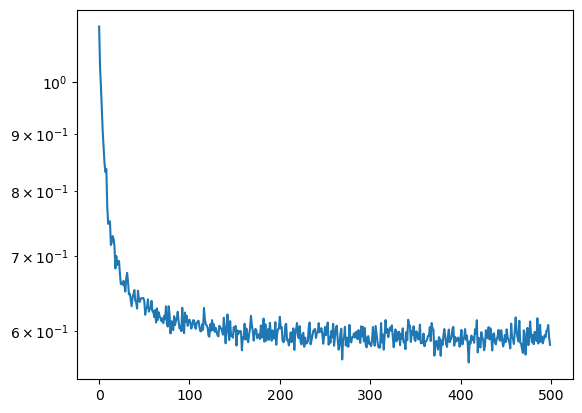

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

 20%|██        | 2/10 [00:02<00:08,  1.08s/it]

 30%|███       | 3/10 [00:03<00:08,  1.26s/it]

 40%|████      | 4/10 [00:04<00:07,  1.20s/it]

 50%|█████     | 5/10 [00:05<00:05,  1.19s/it]

 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

 70%|███████   | 7/10 [00:08<00:03,  1.13s/it]

 80%|████████  | 8/10 [00:09<00:02,  1.15s/it]

 90%|█████████ | 9/10 [00:10<00:01,  1.13s/it]

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Test Loss: 0.5918


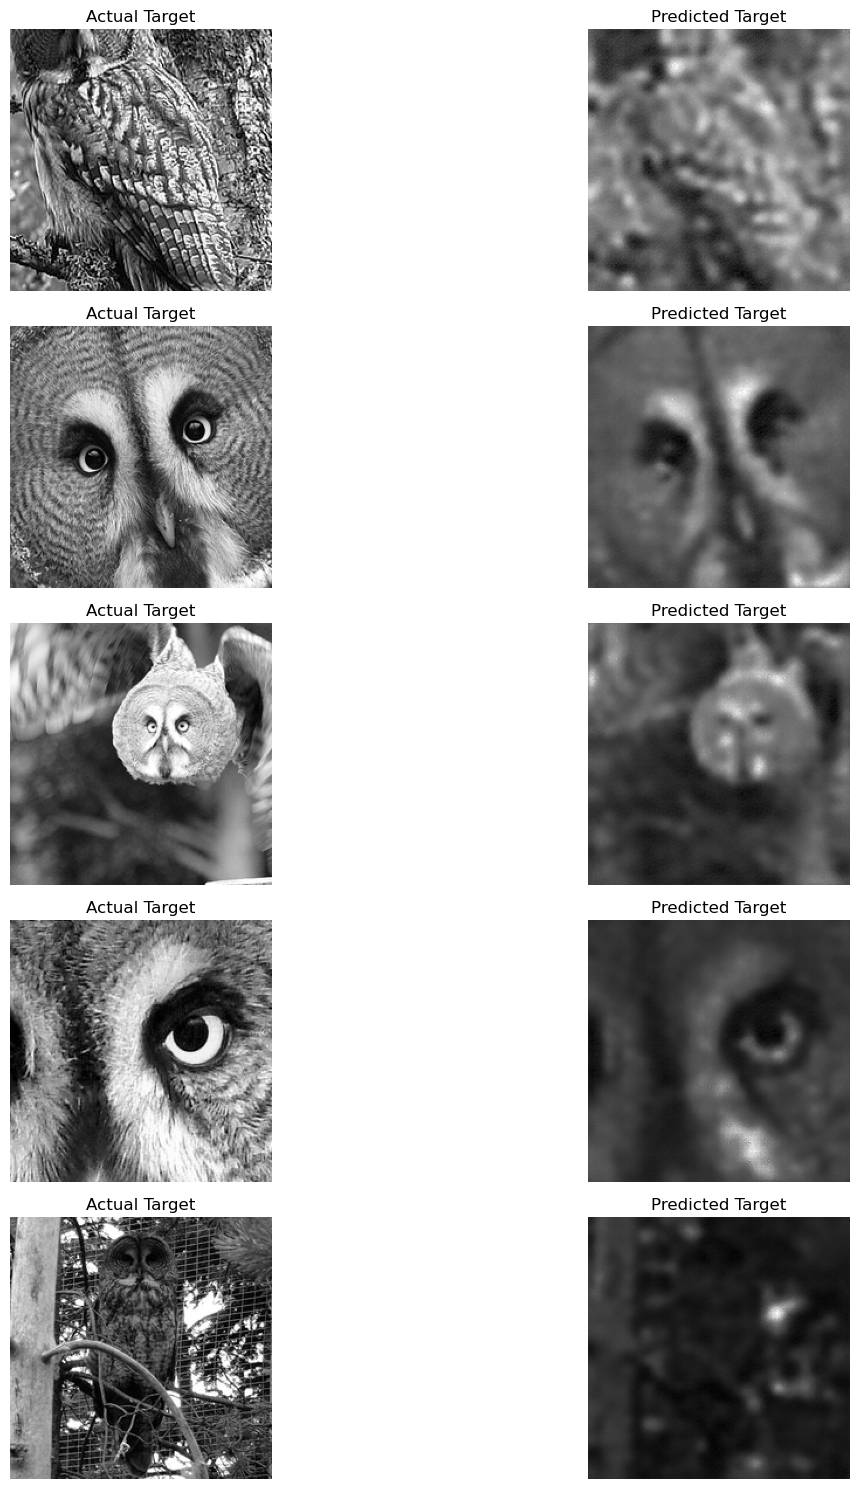

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-3.4050) tensor(23.0161)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))